# 實驗一：房價預測模型

### Import必要套件

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### 數據讀取並分析

In [2]:
data = pd.read_csv("kc_house_data.csv")
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape

(21613, 21)

In [3]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


各個數據的簡寫分別代表下面意思：
- date：房屋出售日期。
- price：房屋價格（目標）。
- bedrooms：臥室數量。
- bathrooms：浴室數量。
- sqft_living：居住的坪數（平方英尺）。
- sqft_lot：實際的坪數（平方英尺）。
- floors：房屋總共樓層。
- waterfront：海景房。
- view：房屋是否看過。
- condition：整體條件有多好。
- grade：房屋的整體等級（根據King County評分系統）。
- sqft_above：除了地下室外的坪數（平方英尺）。
- sqft_basement：地下室的坪數（平方英尺）。
- yr_built：房屋建造時間。
- yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。
- zipcode：郵政編碼。
- lat：緯度座標。
- long：經度座標。
- sqft_living15：2015年紀錄的居住坪數（可能是翻新的原因導致sqft_living15與sqft_living不同）。
- sqft_lot15：2015年紀錄的實際坪數（可能是翻新的原因導致sqft_lot15與sqft_lot不同）。

### 檢查資料的型態

資料型態總共有五種：object(string),booleab, integer, float and categorical.

In [4]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 數據前處理
轉換資料型態：
因為數據集裡的date數據是字串（string）格式，而模型的輸入只接受數值格式，所以可以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [5]:
# 將date日期拆為年、月和日並轉成數值
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除沒有用的數據，inplace則是將更新後的資料存回原本的地方
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集（Dataset）：將數據集切割成三個部份，訓練數據（Training data）、驗證數據（Validation data）和測試數據（Testing data）。

In [6]:
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

### Normalization 正規化

使用標準分數(Standard Score, 又稱z-score)將數據正規化，經過z-score正規化後數據的都會聚集在0附近， 標準差為1。 

(x - 平均值) / 標準差

In [7]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

### 建立Numpy array格式的訓練數據

In [8]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])

整理過後的資料共12967筆，且一筆資料有21種資訊(所以網路輸入必須為21)。

In [9]:
x_train.shape

(12967, 21)

### 建立並訓練網路模型

這裡建構三層全連接層的網路架構，並且使用ReLU作為隱藏層的激活函數，而由於需得到線性輸出，故輸出層不使用任何激活函數。

In [10]:
# 建立一個Sequential型態的model
model = keras.Sequential(name='model-1')
# 第1層全連接層設為64個unit，將輸入形狀設定為(21, )，而實際上我們輸入的數據形狀為(batch_size, 21)
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))
# 第2層全連接層設為64個unit
model.add(layers.Dense(64, activation='relu'))
# 最後一層全連接層設為1個unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

Model: " model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數：

In [11]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

創建模型儲存目錄：

In [13]:
model_dir = 'lab2-logs/models/'
os.makedirs(model_dir)

設定回調函數：

In [14]:
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                        monitor='val_mean_absolute_error', 
                                        save_best_only=True, 
                                        mode='min')

訓練網路模型：

In [15]:
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為64
               epochs=300,  # 整個dataset訓練300遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 65us/sample - loss: 0.3152 - mean_absolute_error: 0.3445 - val_loss: 0.2375 - val_mean_absolute_error: 0.3084
Epoch 2/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.2113 - mean_absolute_error: 0.2852 - val_loss: 0.2088 - val_mean_absolute_error: 0.2814
Epoch 3/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.1820 - mean_absolute_error: 0.2656 - val_loss: 0.1736 - val_mean_absolute_error: 0.2593
Epoch 4/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.1680 - mean_absolute_error: 0.2531 - val_loss: 0.1652 - val_mean_absolute_error: 0.2605
Epoch 5/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.1519 - mean_absolute_error: 0.2405 - val_loss: 0.1554 - val_mean_absolute_error: 0.2417
Epoch 6/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.1431 - 

12967/12967 [==============================] - 0s 28us/sample - loss: 0.0439 - mean_absolute_error: 0.1495 - val_loss: 0.1360 - val_mean_absolute_error: 0.2127
Epoch 96/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0466 - mean_absolute_error: 0.1513 - val_loss: 0.1380 - val_mean_absolute_error: 0.2142
Epoch 97/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0431 - mean_absolute_error: 0.1477 - val_loss: 0.1503 - val_mean_absolute_error: 0.2192
Epoch 98/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0436 - mean_absolute_error: 0.1477 - val_loss: 0.1332 - val_mean_absolute_error: 0.2144
Epoch 99/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0430 - mean_absolute_error: 0.1477 - val_loss: 0.1312 - val_mean_absolute_error: 0.2108
Epoch 100/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0432 - mean_absolute_error: 0.1483 - val_loss: 0.1356 - val_me

12967/12967 [==============================] - 0s 28us/sample - loss: 0.0342 - mean_absolute_error: 0.1360 - val_loss: 0.1436 - val_mean_absolute_error: 0.2175
Epoch 190/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0324 - mean_absolute_error: 0.1328 - val_loss: 0.1416 - val_mean_absolute_error: 0.2166
Epoch 191/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0313 - mean_absolute_error: 0.1311 - val_loss: 0.1467 - val_mean_absolute_error: 0.2248
Epoch 192/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0319 - mean_absolute_error: 0.1317 - val_loss: 0.1485 - val_mean_absolute_error: 0.2204
Epoch 193/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0345 - mean_absolute_error: 0.1360 - val_loss: 0.1368 - val_mean_absolute_error: 0.2191
Epoch 194/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0309 - mean_absolute_error: 0.1301 - val_loss: 0.1386 - va

12967/12967 [==============================] - 0s 29us/sample - loss: 0.0313 - mean_absolute_error: 0.1291 - val_loss: 0.1514 - val_mean_absolute_error: 0.2218
Epoch 284/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0321 - mean_absolute_error: 0.1288 - val_loss: 0.1485 - val_mean_absolute_error: 0.2227
Epoch 285/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0277 - mean_absolute_error: 0.1234 - val_loss: 0.1501 - val_mean_absolute_error: 0.2198
Epoch 286/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0276 - mean_absolute_error: 0.1235 - val_loss: 0.1464 - val_mean_absolute_error: 0.2180
Epoch 287/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0266 - mean_absolute_error: 0.1214 - val_loss: 0.1477 - val_mean_absolute_error: 0.2214
Epoch 288/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0266 - mean_absolute_error: 0.1223 - val_loss: 0.1481 - va

### 訓練結果

In [16]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

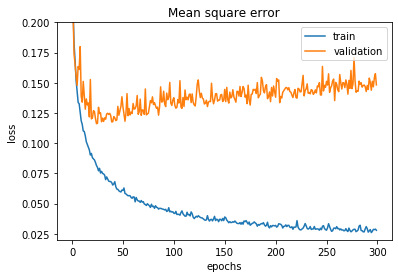

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

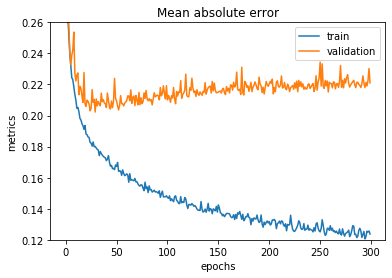

In [20]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

測試數據的誤差百分比：用測試數據預測房屋價格並與答案計算誤差百分比。

In [19]:
# 載入模型
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測測試數據
y_pred = model.predict(x_test)
# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

Model_1 Percentage Error: 14.08%


### TensorBoard 可視化工具

In [23]:
# 這行指令可以幫助我們直接在jupyter notebook上顯示TensorBoard
%load_ext tensorboard

In [24]:
%tensorboard --port 9530 --logdir lab2-logs

# 實驗二：過擬合問題

### 方法一、減少網路權重

In [19]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(21,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_2.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 42us/sample - loss: 0.5637 - mean_absolute_error: 0.4461 - val_loss: 0.3118 - val_mean_absolute_error: 0.3467
Epoch 2/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.2780 - mean_absolute_error: 0.3281 - val_loss: 0.2506 - val_mean_absolute_error: 0.3037
Epoch 3/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.2415 - mean_absolute_error: 0.3046 - val_loss: 0.2276 - val_mean_absolute_error: 0.2885
Epoch 4/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.2217 - mean_absolute_error: 0.2909 - val_loss: 0.2073 - val_mean_absolute_error: 0.2799
Epoch 5/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.2080 - mean_absolute_error: 0.2820 - val_loss: 0.1948 - val_mean_absolute_error: 0.2725
Epoch 6/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.1973 - 

12967/12967 [==============================] - 0s 29us/sample - loss: 0.0872 - mean_absolute_error: 0.1886 - val_loss: 0.1251 - val_mean_absolute_error: 0.2002
Epoch 96/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0870 - mean_absolute_error: 0.1878 - val_loss: 0.1237 - val_mean_absolute_error: 0.1975
Epoch 97/300
12967/12967 [==============================] - 0s 28us/sample - loss: 0.0863 - mean_absolute_error: 0.1885 - val_loss: 0.1224 - val_mean_absolute_error: 0.1986
Epoch 98/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0869 - mean_absolute_error: 0.1889 - val_loss: 0.1234 - val_mean_absolute_error: 0.2042
Epoch 99/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0872 - mean_absolute_error: 0.1881 - val_loss: 0.1191 - val_mean_absolute_error: 0.1971
Epoch 100/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0864 - mean_absolute_error: 0.1876 - val_loss: 0.1324 - val_me

12967/12967 [==============================] - 0s 29us/sample - loss: 0.0765 - mean_absolute_error: 0.1799 - val_loss: 0.1227 - val_mean_absolute_error: 0.1935
Epoch 190/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0757 - mean_absolute_error: 0.1791 - val_loss: 0.1224 - val_mean_absolute_error: 0.1947
Epoch 191/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0757 - mean_absolute_error: 0.1799 - val_loss: 0.1283 - val_mean_absolute_error: 0.1991
Epoch 192/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0760 - mean_absolute_error: 0.1795 - val_loss: 0.1244 - val_mean_absolute_error: 0.1933
Epoch 193/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0750 - mean_absolute_error: 0.1787 - val_loss: 0.1259 - val_mean_absolute_error: 0.1948
Epoch 194/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0776 - mean_absolute_error: 0.1820 - val_loss: 0.1213 - va

12967/12967 [==============================] - 0s 29us/sample - loss: 0.0726 - mean_absolute_error: 0.1764 - val_loss: 0.1261 - val_mean_absolute_error: 0.1954
Epoch 284/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0728 - mean_absolute_error: 0.1779 - val_loss: 0.1219 - val_mean_absolute_error: 0.1945
Epoch 285/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0722 - mean_absolute_error: 0.1767 - val_loss: 0.1266 - val_mean_absolute_error: 0.1945
Epoch 286/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0725 - mean_absolute_error: 0.1775 - val_loss: 0.1252 - val_mean_absolute_error: 0.1952
Epoch 287/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0734 - mean_absolute_error: 0.1777 - val_loss: 0.1333 - val_mean_absolute_error: 0.1971
Epoch 288/300
12967/12967 [==============================] - 0s 29us/sample - loss: 0.0721 - mean_absolute_error: 0.1762 - val_loss: 0.1267 - va

### 加入L1或L2 正則化

In [20]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, 
                         kernel_regularizer=keras.regularizers.l2(0.001), 
                         activation='relu', input_shape=(21,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_3.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 52us/sample - loss: 0.3835 - mean_absolute_error: 0.3362 - val_loss: 0.2921 - val_mean_absolute_error: 0.2824
Epoch 2/300
12967/12967 [==============================] - 0s 32us/sample - loss: 0.2892 - mean_absolute_error: 0.2813 - val_loss: 0.2878 - val_mean_absolute_error: 0.2684
Epoch 3/300
12967/12967 [==============================] - 0s 32us/sample - loss: 0.2592 - mean_absolute_error: 0.2659 - val_loss: 0.2510 - val_mean_absolute_error: 0.2648
Epoch 4/300
12967/12967 [==============================] - 0s 32us/sample - loss: 0.2401 - mean_absolute_error: 0.2571 - val_loss: 0.2331 - val_mean_absolute_error: 0.2509
Epoch 5/300
12967/12967 [==============================] - 0s 32us/sample - loss: 0.2236 - mean_absolute_error: 0.2473 - val_loss: 0.2209 - val_mean_absolute_error: 0.2390
Epoch 6/300
12967/12967 [==============================] - 0s 32us/sample - loss: 0.2083 - 

12967/12967 [==============================] - 0s 31us/sample - loss: 0.0881 - mean_absolute_error: 0.1685 - val_loss: 0.1235 - val_mean_absolute_error: 0.1854
Epoch 96/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0947 - mean_absolute_error: 0.1738 - val_loss: 0.1242 - val_mean_absolute_error: 0.1892
Epoch 97/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0893 - mean_absolute_error: 0.1686 - val_loss: 0.1242 - val_mean_absolute_error: 0.1836
Epoch 98/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0889 - mean_absolute_error: 0.1688 - val_loss: 0.1311 - val_mean_absolute_error: 0.1859
Epoch 99/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0868 - mean_absolute_error: 0.1672 - val_loss: 0.1290 - val_mean_absolute_error: 0.1883
Epoch 100/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0874 - mean_absolute_error: 0.1672 - val_loss: 0.1451 - val_me

12967/12967 [==============================] - 0s 31us/sample - loss: 0.0790 - mean_absolute_error: 0.1619 - val_loss: 0.1361 - val_mean_absolute_error: 0.1871
Epoch 190/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0776 - mean_absolute_error: 0.1606 - val_loss: 0.1204 - val_mean_absolute_error: 0.1866
Epoch 191/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0765 - mean_absolute_error: 0.1607 - val_loss: 0.1236 - val_mean_absolute_error: 0.1843
Epoch 192/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0800 - mean_absolute_error: 0.1633 - val_loss: 0.1230 - val_mean_absolute_error: 0.1865
Epoch 193/300
12967/12967 [==============================] - 0s 32us/sample - loss: 0.0753 - mean_absolute_error: 0.1591 - val_loss: 0.1227 - val_mean_absolute_error: 0.1839
Epoch 194/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0782 - mean_absolute_error: 0.1604 - val_loss: 0.1280 - va

12967/12967 [==============================] - 0s 31us/sample - loss: 0.0727 - mean_absolute_error: 0.1584 - val_loss: 0.1205 - val_mean_absolute_error: 0.1889
Epoch 284/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0735 - mean_absolute_error: 0.1580 - val_loss: 0.1197 - val_mean_absolute_error: 0.1865
Epoch 285/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0752 - mean_absolute_error: 0.1592 - val_loss: 0.1288 - val_mean_absolute_error: 0.1897
Epoch 286/300
12967/12967 [==============================] - 0s 30us/sample - loss: 0.0767 - mean_absolute_error: 0.1606 - val_loss: 0.1252 - val_mean_absolute_error: 0.1964
Epoch 287/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0811 - mean_absolute_error: 0.1645 - val_loss: 0.1235 - val_mean_absolute_error: 0.1856
Epoch 288/300
12967/12967 [==============================] - 0s 31us/sample - loss: 0.0728 - mean_absolute_error: 0.1571 - val_loss: 0.1202 - va

### 加入 Dropout

In [31]:
model_4 = keras.Sequential(name='model-4')
model_4.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(1))

model_4.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_4.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Train on 12967 samples, validate on 4323 samples
Epoch 1/300
12967/12967 [==============================] - 1s 59us/sample - loss: 0.5470 - mean_absolute_error: 0.4688 - val_loss: 0.2764 - val_mean_absolute_error: 0.3119
Epoch 2/300
12967/12967 [==============================] - 0s 37us/sample - loss: 0.3332 - mean_absolute_error: 0.3627 - val_loss: 0.2323 - val_mean_absolute_error: 0.2979
Epoch 3/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.2863 - mean_absolute_error: 0.3357 - val_loss: 0.2092 - val_mean_absolute_error: 0.2846
Epoch 4/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.2742 - mean_absolute_error: 0.3227 - val_loss: 0.2288 - val_mean_absolute_error: 0.2828
Epoch 5/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.2432 - mean_absolute_error: 0.3073 - val_loss: 0.2353 - val_mean_absolute_error: 0.2853
Epoch 6/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.2443 - 

12967/12967 [==============================] - 0s 35us/sample - loss: 0.1160 - mean_absolute_error: 0.2192 - val_loss: 0.1170 - val_mean_absolute_error: 0.2103
Epoch 96/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.1130 - mean_absolute_error: 0.2183 - val_loss: 0.1146 - val_mean_absolute_error: 0.2117
Epoch 97/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1210 - mean_absolute_error: 0.2198 - val_loss: 0.1224 - val_mean_absolute_error: 0.2147
Epoch 98/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1275 - mean_absolute_error: 0.2227 - val_loss: 0.1078 - val_mean_absolute_error: 0.2062
Epoch 99/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.1203 - mean_absolute_error: 0.2210 - val_loss: 0.1189 - val_mean_absolute_error: 0.2172
Epoch 100/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.1196 - mean_absolute_error: 0.2177 - val_loss: 0.1140 - val_me

12967/12967 [==============================] - 0s 36us/sample - loss: 0.1136 - mean_absolute_error: 0.2145 - val_loss: 0.1387 - val_mean_absolute_error: 0.2232
Epoch 190/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1145 - mean_absolute_error: 0.2142 - val_loss: 0.1301 - val_mean_absolute_error: 0.2260
Epoch 191/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1134 - mean_absolute_error: 0.2150 - val_loss: 0.1180 - val_mean_absolute_error: 0.2065
Epoch 192/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1148 - mean_absolute_error: 0.2146 - val_loss: 0.1556 - val_mean_absolute_error: 0.2340
Epoch 193/300
12967/12967 [==============================] - ETA: 0s - loss: 0.1094 - mean_absolute_error: 0.215 - 0s 35us/sample - loss: 0.1099 - mean_absolute_error: 0.2157 - val_loss: 0.1284 - val_mean_absolute_error: 0.2107
Epoch 194/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1188

Epoch 236/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.1098 - mean_absolute_error: 0.2142 - val_loss: 0.1235 - val_mean_absolute_error: 0.2189
Epoch 237/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1099 - mean_absolute_error: 0.2138 - val_loss: 0.1056 - val_mean_absolute_error: 0.2133
Epoch 238/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1092 - mean_absolute_error: 0.2133 - val_loss: 0.1038 - val_mean_absolute_error: 0.2058
Epoch 239/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.1053 - mean_absolute_error: 0.2119 - val_loss: 0.1025 - val_mean_absolute_error: 0.1991
Epoch 240/300
12967/12967 [==============================] - 0s 36us/sample - loss: 0.1150 - mean_absolute_error: 0.2129 - val_loss: 0.1273 - val_mean_absolute_error: 0.2255
Epoch 241/300
12967/12967 [==============================] - 0s 35us/sample - loss: 0.1085 - mean_absolute_error: 0.2124 - val_los

### 驗證正則化的效能

Test model 2:

In [26]:
model_2 = keras.models.load_model('lab2-logs/models/Best-model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_2: {:.2f}%".format(percentage_error))

Model_2: 13.15%


Test model 3:

In [27]:
model_3 = keras.models.load_model('lab2-logs/models/Best-model-3.h5')
y_pred = model_3.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_3: {:.2f}%".format(percentage_error))

Model_3: 12.89%


Test model 4:

In [32]:
model_4 = keras.models.load_model('lab2-logs/models/Best-model-4.h5')
y_pred = model_4.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_4: {:.2f}%".format(percentage_error))

Model_4: 13.33%
